In [2]:
import pandas as pd
import torch
import json
import numpy as np
from tqdm import tqdm
import glob

from orderbook import OrderbookState, RawEvent, EventType
from pipeline_logger import TickStore
from features import compute_micro_features
from models import ProbDistributionMLP, make_default_grid, predict_with_uncertainty


In [3]:
MARKET = "KXNCAAFGAME-25DEC24CALHAW-HAW"

parquet_glob = "data/ticks/*.parquet"
ckpt_path = f"models_ckpts/{MARKET}.pt"
norm_path = f"normalization/{MARKET}_norm.pt"

files = sorted(glob.glob(parquet_glob))
df = pd.concat([pd.read_parquet(f) for f in files])

df = (
    df[df["market_id"] == MARKET]
      .sort_values("ts_exchange")
      .reset_index(drop=True)
)

grid = make_default_grid(K=21)
d_in = 8

model = ProbDistributionMLP(
    d_in=d_in,
    K=grid.K,
    hidden_sizes=(64,32),
    dropout_p=0.1,
)

state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)

norm = torch.load(norm_path, map_location=device)
norm_mean = norm["mean"]
norm_std = norm["std"]
book = OrderbookState(market_id=MARKET)
ticks = TickStore(storage_path="scratch_eval/", flush_threshold=10**9)

eval_rows = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    evt = RawEvent(
        ts_exchange=float(row.ts_exchange),
        ts_ingest=float(row.ts_exchange),
        market_id=MARKET,
        type=EventType(row.event_type),
        payload=json.loads(row.payload),
        seq=row.seq if not pd.isna(row.seq) else None,
    )

    ticks.record_event(evt, team_info={})
    book.apply_event(evt)

    if evt.type != EventType.QUOTE:
        continue

    x = compute_micro_features(
        book=book,
        ticks=ticks,
        as_of_ts=evt.ts_exchange,
        meta=None,
    )

    
    x_norm = (x - norm_mean) / (norm_std + 1e-6)

    mean_probs, mean_p, var_p = predict_with_uncertainty(
        model=model,
        grid=grid,
        features=x_norm,
        n_samples=10
    )

    eval_rows.append({
        "t": evt.ts_exchange,
        "midpoint": feats.midpoint,
        "spread": feats.spread,
        "quote_velocity": feats.quote_velocity,
        "depth_imbalance": feats.depth_imbalance,
        "trade_imbalance": feats.trade_imbalance,
        "quote_staleness": feats.quote_staleness,
        "mean_p": mean_p,
        "var_p": var_p,
        "entropy": float(-(mean_probs * (mean_probs+1e-12).log()).sum()),
        "width": float((mean_probs * (grid.values - mean_p)**2).sum()),
        "probs": mean_probs.numpy(),
    })

ev = pd.DataFrame(eval_rows)

TypeError: ProbDistributionMLP.__init__() got an unexpected keyword argument 'hidden_sizes'

In [ ]:
def count_turns(probs: np.ndarray) -> int:
    d = np.diff(probs)
    s = np.sign(d)
    return int((s[:-1] != s[1:]).sum())

def peak_count(probs: np.ndarray, tol=1e-4) -> int:
    # count local maxima above a small tolerance
    p = probs
    peaks = 0
    for i in range(1, len(p) - 1):
        if p[i] > p[i-1] + tol and p[i] > p[i+1] + tol:
            peaks += 1
    return peaks


In [ ]:
ev["turns"] = ev["probs"].apply(count_turns)
ev["peaks"] = ev["probs"].apply(peak_count)

# crude flags
ev["is_multimodal"] = ev["peaks"] > 1
ev["is_wiggly"] = ev["turns"] > 3


In [ ]:
bad = ev[ev["is_multimodal"] | ev["is_wiggly"]]
len(bad), bad.head()


(19307,
               t  midpoint  spread  quote_velocity  depth_imbalance  \
 0  1.766631e+09     0.185    0.01             0.1        -0.996867   
 1  1.766631e+09     0.185    0.01             0.2        -0.996867   
 2  1.766631e+09     0.185    0.01             0.3        -0.996867   
 3  1.766631e+09     0.185    0.01             0.4        -0.996867   
 5  1.766631e+09     0.185    0.01             0.6        -0.996867   
 
    trade_imbalance  quote_staleness    mean_p     var_p   entropy     width  \
 0              0.0              0.0  0.186809  0.000006  1.590635  0.003470   
 1              0.0              0.0  0.187333  0.000003  1.598830  0.003690   
 2              0.0              0.0  0.187694  0.000005  1.608267  0.003908   
 3              0.0              0.0  0.186801  0.000013  1.639987  0.004486   
 5              0.0              0.0  0.186129  0.000002  1.593327  0.003451   
 
                                                probs  turns  peaks  \
 0  [0.0118

## Inspecting bad cases

In [ ]:
kvals = grid.values.numpy()

def show_case(idx: int):
    row = ev.loc[idx]
    prev_row = ev.loc[idx-1] if idx > 0 else None
    next_row = ev.loc[idx+1] if idx+1 in ev.index else None

    plt.figure(figsize=(8,5))
    plt.plot(kvals, row["probs"], label=f"t={row['t']:.3f}")
    if prev_row is not None:
        plt.plot(kvals, prev_row["probs"], "--", alpha=0.6, label="prev")
    if next_row is not None:
        plt.plot(kvals, next_row["probs"], ":", alpha=0.6, label="next")

    plt.title("Pathological case: implied distribution around t")
    plt.xlabel("Probability grid (pk)")
    plt.ylabel("Probability mass")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("t:                ", row["t"])
    print("midpoint:         ", row["midpoint"])
    print("spread:           ", row["spread"])
    print("quote_velocity:   ", row["quote_velocity"])
    print("depth_imbalance:  ", row["depth_imbalance"])
    print("trade_imbalance:  ", row["trade_imbalance"])
    print("quote_staleness:  ", row["quote_staleness"])
    print("mean_p:           ", row["mean_p"])
    print("var_p:            ", row["var_p"])
    print("width:            ", row["width"])
    print("entropy:          ", row["entropy"])
    print("peaks / turns:    ", row["peaks"], "/", row["turns"])


In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

def format_plot(
    title: str,
    subtitle: str = "",
    xlabel: str = "",
    ylabel: str = "",
    note: str = "",
):
    plt.title(
        f"{title}\n"
        f"{subtitle}",
        fontsize=13,
        loc="left",
    )
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)

    if note:
        plt.figtext(
            0.01, -0.04,
            f"Note: {note}",
            fontsize=9,
            ha="left"
        )

    plt.grid(alpha=0.25)
    plt.tight_layout()


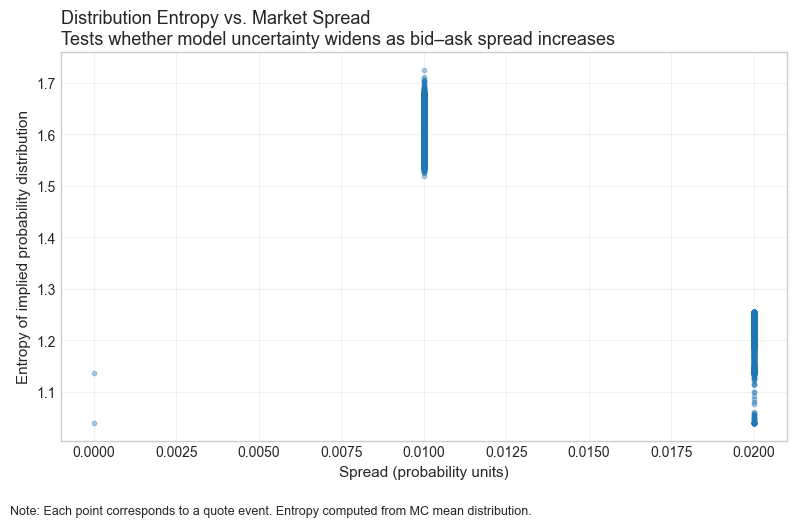

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(ev["spread"], ev["entropy"], s=10, alpha=0.35)

format_plot(
    title="Distribution Entropy vs. Market Spread",
    subtitle="Tests whether model uncertainty widens as bid–ask spread increases",
    xlabel="Spread (probability units)",
    ylabel="Entropy of implied probability distribution",
    note="Each point corresponds to a quote event. Entropy computed from MC mean distribution."
)

plt.show()


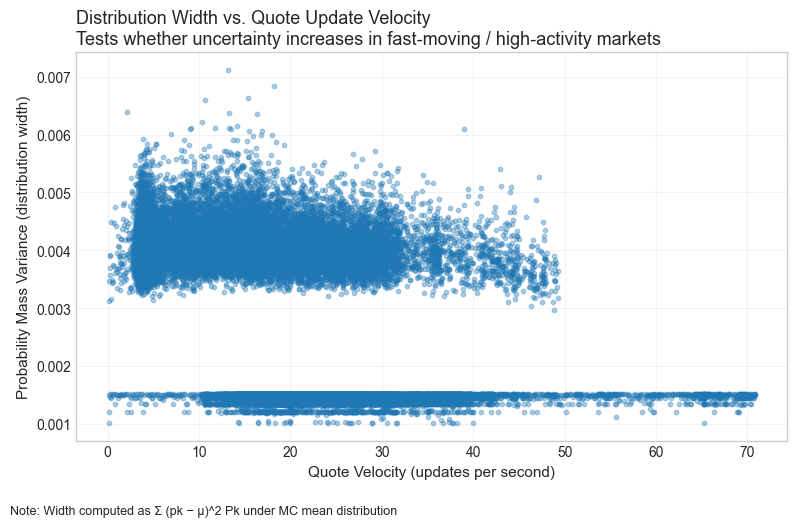

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(ev["quote_velocity"], ev["width"], s=10, alpha=0.35)

format_plot(
    title="Distribution Width vs. Quote Update Velocity",
    subtitle="Tests whether uncertainty increases in fast-moving / high-activity markets",
    xlabel="Quote Velocity (updates per second)",
    ylabel="Probability Mass Variance (distribution width)",
    note="Width computed as Σ (pk − μ)^2 Pk under MC mean distribution"
)

plt.show()


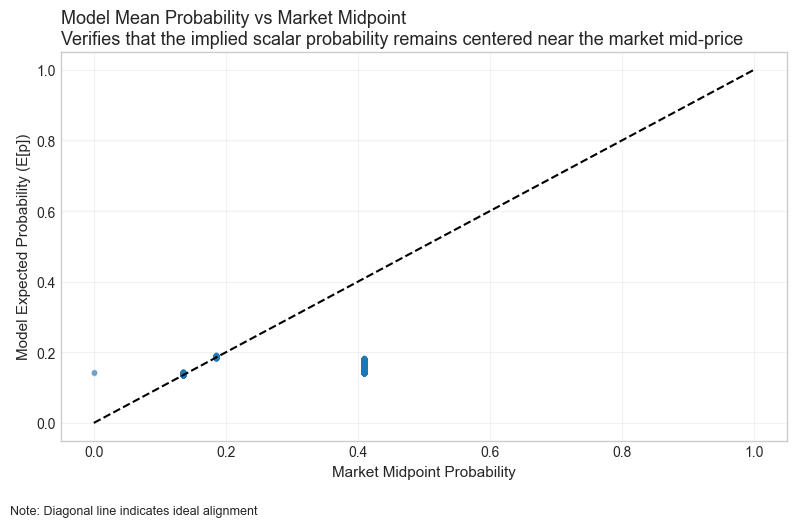

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(ev["midpoint"], ev["mean_p"], s=10, alpha=0.35)

plt.plot([0,1],[0,1], "--", color="black")

format_plot(
    title="Model Mean Probability vs Market Midpoint",
    subtitle="Verifies that the implied scalar probability remains centered near the market mid-price",
    xlabel="Market Midpoint Probability",
    ylabel="Model Expected Probability (E[p])",
    note="Diagonal line indicates ideal alignment"
)

plt.show()


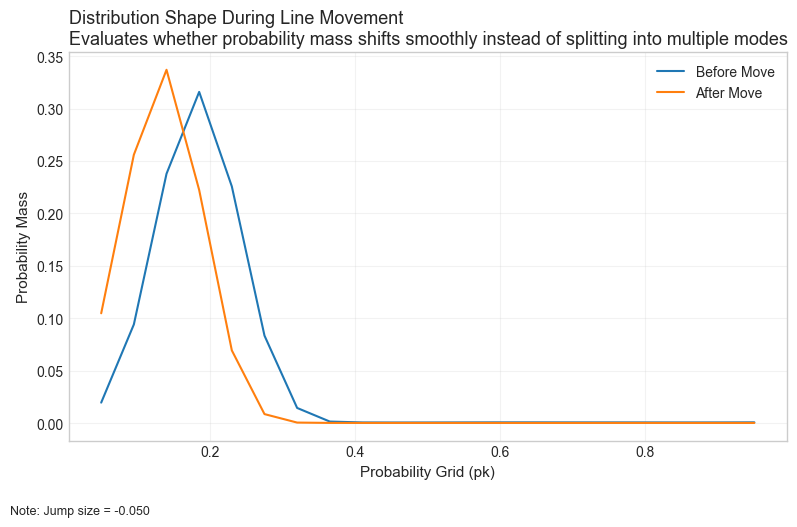

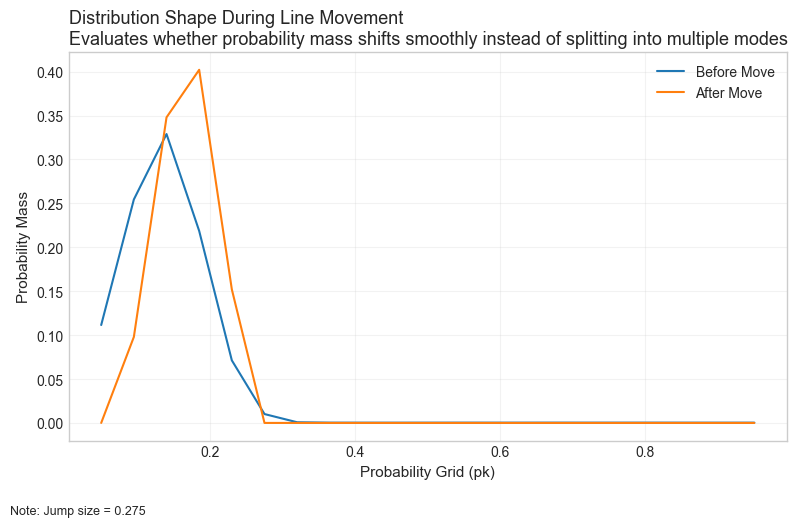

In [ ]:
ev["midpoint_diff"] = ev["midpoint"].diff()
jumps = ev[ev["midpoint_diff"].abs() > 0.03]

kvals = grid.values.numpy()

for i in range(2):
    idx = jumps.index[i]

    before = ev.loc[idx-1, "probs"]
    after = ev.loc[idx, "probs"]

    plt.figure(figsize=(8,5))
    plt.plot(kvals, before, label="Before Move")
    plt.plot(kvals, after, label="After Move")

    format_plot(
        title="Distribution Shape During Line Movement",
        subtitle="Evaluates whether probability mass shifts smoothly instead of splitting into multiple modes",
        xlabel="Probability Grid (pk)",
        ylabel="Probability Mass",
        note=f"Jump size = {ev.loc[idx,'midpoint_diff']:.3f}"
    )

    plt.legend()
    plt.show()


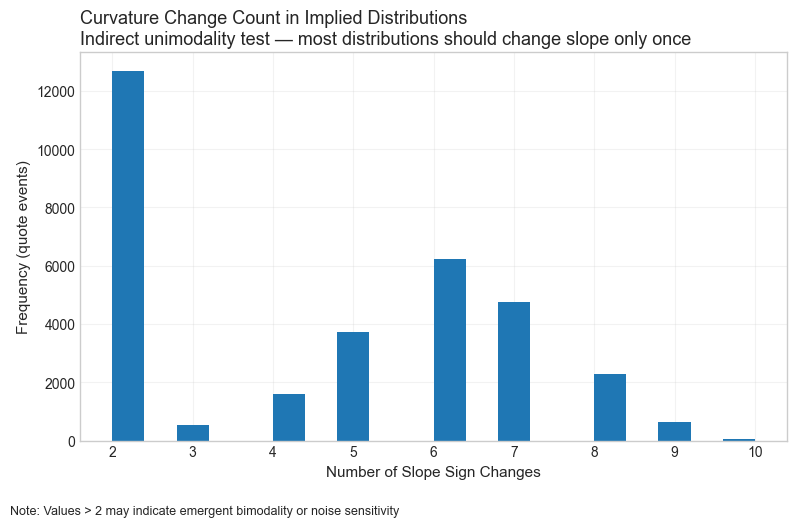

In [ ]:
import numpy as np

def count_sign_changes(probs):
    d = np.diff(probs)
    s = np.sign(d)
    return (s[:-1] != s[1:]).sum()

ev["shape_turns"] = ev["probs"].apply(count_sign_changes)

plt.figure(figsize=(8,5))
ev["shape_turns"].hist(bins=20)

format_plot(
    title="Curvature Change Count in Implied Distributions",
    subtitle="Indirect unimodality test — most distributions should change slope only once",
    xlabel="Number of Slope Sign Changes",
    ylabel="Frequency (quote events)",
    note="Values > 2 may indicate emergent bimodality or noise sensitivity"
)

plt.show()


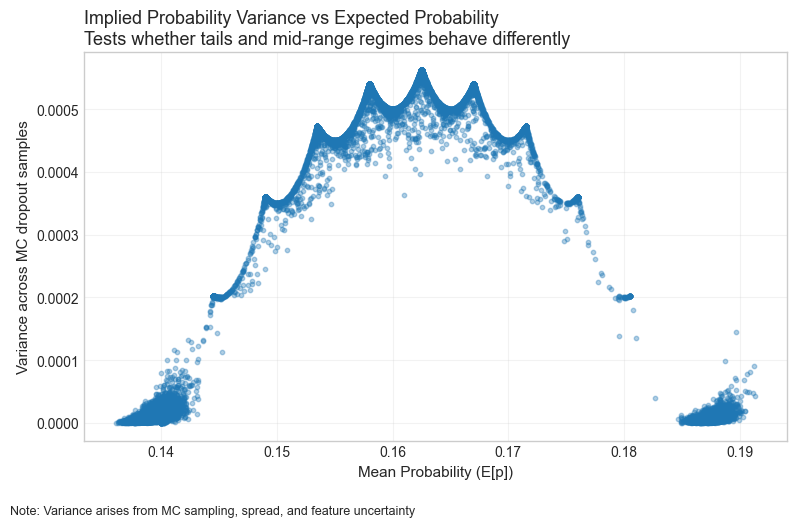

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(ev["mean_p"], ev["var_p"], s=10, alpha=0.35)

format_plot(
    title="Implied Probability Variance vs Expected Probability",
    subtitle="Tests whether tails and mid-range regimes behave differently",
    xlabel="Mean Probability (E[p])",
    ylabel="Variance across MC dropout samples",
    note="Variance arises from MC sampling, spread, and feature uncertainty"
)

plt.show()
